# vCAT MVPA Analysis using SKLearn
## All Runs (1, 2, 3, & 4)
## Feature regions - HPC, mPFC, & DAC

In [13]:
import os
from os.path import join, basename, exists
import shutil
import pickle as pkl
from glob import glob
from natsort import natsorted
import pandas as pd
import numpy as np
import nibabel as nb
from scipy import stats
from sklearn import svm
from sklearn.model_selection import LeavePOut
import seaborn as sns
from pylab import *
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("white")
sns.set_palette('muted')

In [2]:
subs = ['sub-005', 'sub-006', 'sub-007', 'sub-008', 'sub-010', 
        'sub-012', 'sub-013', 'sub-014', 'sub-015', 'sub-016', 
        'sub-018', 'sub-019', 'sub-020', 'sub-021', 'sub-022', 
        'sub-023', 'sub-024', 'sub-025', 'sub-026', 'sub-027', 
        'sub-028', 'sub-029', 'sub-030', 'sub-031', 'sub-032']

subs1 = ['sub-005']
proj_dir = '/home/data/madlab/Mattfeld_vCAT' 

mask_data = []
task_data = [] 
behav_data = []

for i, sub in enumerate(subs):
    #mask_glob = glob(join(proj_dir, 'derivatives/roi_masks', sub, 'bi-*.nii.gz')) #FS masks
    mask_glob = glob(join(proj_dir, 'derivatives/roi_masks', sub, 'bi-*.nii.gz')) #FS x LOC masks
    mask_data.append(sorted(mask_glob))
    task_glob = glob(join(proj_dir, 'derivatives/MVPA-LSS', sub, 'cope_*.nii.gz')) #LSS cope files
    task_data.append(natsorted(task_glob))
    behav_glob = glob(join(proj_dir, 'behav', sub, '{0}_simp_task*.csv'.format(sub))) #Runs 1-4 task files
    behav_data.append(sorted(behav_glob))

In [3]:
for i, curr_mask in enumerate(mask_data[0]): #FS X LOC mask indices and filenames
    print(i, mask_data[0][i].split('/')[-1]) 

0 bi-caudate.nii.gz
1 bi-fusiform.nii.gz
2 bi-hippocampus.nii.gz
3 bi-mPFC.nii.gz
4 bi-parahippocampal.nii.gz
5 bi-putamen.nii.gz


In [4]:
for i, curr_face in enumerate(task_data[0]): #cope data indices and filenames
    print(i, task_data[0][i].split('/')[-1]) 

0 cope_face_run1_trl1_onset6.30.nii.gz
1 cope_face_run1_trl2_onset44.80.nii.gz
2 cope_face_run1_trl3_onset97.82.nii.gz
3 cope_face_run1_trl4_onset124.32.nii.gz
4 cope_face_run1_trl5_onset212.33.nii.gz
5 cope_face_run1_trl6_onset220.82.nii.gz
6 cope_face_run1_trl7_onset243.82.nii.gz
7 cope_face_run1_trl8_onset305.33.nii.gz
8 cope_face_run1_trl9_onset313.83.nii.gz
9 cope_face_run1_trl10_onset336.83.nii.gz
10 cope_face_run1_trl11_onset371.83.nii.gz
11 cope_face_run1_trl12_onset412.83.nii.gz
12 cope_face_run1_trl13_onset452.83.nii.gz
13 cope_face_run1_trl14_onset509.33.nii.gz
14 cope_face_run1_trl15_onset517.83.nii.gz
15 cope_face_run1_trl16_onset579.83.nii.gz
16 cope_face_run2_trl1_onset56.80.nii.gz
17 cope_face_run2_trl2_onset77.30.nii.gz
18 cope_face_run2_trl3_onset91.80.nii.gz
19 cope_face_run2_trl4_onset100.30.nii.gz
20 cope_face_run2_trl5_onset120.80.nii.gz
21 cope_face_run2_trl6_onset147.30.nii.gz
22 cope_face_run2_trl7_onset155.80.nii.gz
23 cope_face_run2_trl8_onset200.30.nii.gz
24

In [5]:
for i, curr_behav in enumerate(behav_data[0]): #behavioral data indices and filenames
    print(i, behav_data[0][i].split('/')[-1].split('_')[-1]) 

0 task1.csv
1 task2.csv
2 task3.csv
3 task4.csv


### Create dict organizing all data into parallel keys/values

In [6]:
all_data = {'subjid':[], 'labels':[], 'samples':[], 'svc_acc':[], 'sub_acc':[], 'face_fscores':[], 'scene_fscores':[]}

for i in range(len(subs)): #organize data into dict
    all_data['subjid'].append(subs[i])
    #obtain face/scene labels from each cope filename
    curr_labels = [] #array to append subject labels to all_data
    for j, cope in enumerate(task_data[i]):
        if task_data[i][j].split('/')[-1].split('_')[1] == 'face': #current cope filename includes "face"
            curr_labels.append(0) #face = 0
        else: #current cope filename does not includes "face"
            curr_labels.append(1) #scene = 1
    all_data['labels'].append(curr_labels) #subject labels --> all_data 
    
    #mask copes to obtain feature space for each SVC 
    dac_mask = nb.load(mask_data[i][0]) 
    hpc_mask = nb.load(mask_data[i][2]) 
    mpfc_mask = nb.load(mask_data[i][3]) 
    
    mask = hpc_mask.get_fdata() + mpfc_mask.get_fdata() + dac_mask.get_fdata() #combine into single mask
    mask_idx = np.where(mask > 1.) #looks for possible overlap between masks
    mask[mask_idx] = 1 #reassigns possible overlap voxels to 1
    masked_samples = [] #array to append subject samples to all_data
    for cope in task_data[i]: #iterate through subject copes (120)
        curr_cope = nb.load(cope) #load current subject cope with Nibabel       
        data = curr_cope.get_fdata()[mask > 0.] #use mask to isolate ROI voxels of cope
        masked_samples.append(data) 
    all_data['samples'].append(masked_samples)    

    #calculate subject accuracies for face and scene conditional trials
    set_acc = []  #array of subject set accuracies to average before appending to all_data
    for j in range(2): #iterate through sets
        run1 = pd.read_csv(behav_data[i][j*2]) #subject data csv 
        run2 = pd.read_csv(behav_data[i][j*2+1]) 
        curr_set = run1.append(run2, ignore_index=True) #concatenate Run 1 and 2 dataframes       
        trialtype = curr_set['trialtype'].values #convert dataframes into numpy arrays
        acc = curr_set['acc'].values
        stim = curr_set['stim'].values        
        all_cond = len(np.where((trialtype == 'cond'))[0]) #all conditional trials
        corr_cond = len(np.where((trialtype == 'cond') & (acc == 1))[0]) #correct conditionals           
        set_acc.append(corr_cond/all_cond) #append subject conditional accuracy for current set
    all_data['sub_acc'].append(np.mean(set_acc)) #mean subject for both sets --> all_data
    
    #SVC
    splitter = LeavePOut(p=1) #Leave one sample out (LOSO) training method
    X = np.array(all_data['samples'][i]) #masked samples
    Y = np.array(all_data['labels'][i]) #face/scene labels (faces = 0, scenes = 1)
    binary_scores = [] #binary SVC accuracy (n=120)  
    true_pos_face, false_neg_face, false_pos_face = 0, 0, 0 #initial values for FACE F-score calculations
    true_pos_scene, false_neg_scene, false_pos_scene = 0, 0, 0 #initial values for SCENE F-score calculations
    for a, idx in enumerate(splitter.split(X)): #iterate through number of LOSO models (n=120)       
        train_idx, test_idx = idx #indices for current model iteration
        X_train, X_test = X[train_idx], X[test_idx] #current train and test samples
        Y_train, Y_test = Y[train_idx], Y[test_idx] #current train and test labels
        filename = 'completed-3regions/clf_{0:03d}_{1:03d}.pkl'.format(i, a) #name for pickle file (subject and model #)
        if os.path.exists(filename): #if current model has ran before
            with open(filename, 'rb') as f: #open and load existing model pickle
                lin_clf = pkl.load(f)
        else: #if first run of current model       
            lin_clf = svm.LinearSVC(max_iter = 2000) #create SVC, desired number of iterations
            lin_clf.fit(X_train, Y_train) #training data for samples/labels (n=119)
            with open(filename, 'wb') as f: #create and save new model pickle
                pkl.dump(lin_clf, f)
        s = lin_clf.score(X_test, Y_test) #testing data for samples/labels (n=1)
        binary_scores.append(s) #append current SVC binary accuracy
        #condition tree for calculating f-score (harmonic mean) for FACES
        if Y_test[0] == 0: #face trial
            if s: #correct face trial
                true_pos_face += 1 #correctly identifying face as present
            else: #incorrect face trial
                false_neg_face += 1 #incorrectly identifying face as absent
        else: #scene trial
            if not s: #incorrect scene trial
                false_pos_face += 1 #incorrectly identifying face as present
        #condition tree for calculating f-score (harmonic mean) for SCENES
        if Y_test[0] == 1: #scene trial
            if s: #correct scene trial
                true_pos_scene += 1 #correctly identifying scene as present
            else: #incorrect scene trial
                false_neg_scene += 1 #incorrectly identifying scene as absent
        else: #face trial
            if not s: #incorrect face trial
                false_pos_scene += 1 #incorrectly identifying scene as present
    #calculate F-Score for FACES            
    face_precision = true_pos_face/(true_pos_face+false_pos_face) #calculate positive predictive value (precision)
    face_recall = true_pos_face/(true_pos_face+false_neg_face) #calculate sensitivity (recall)
    face_f_score = 2*(face_precision*face_recall/(face_precision+face_recall)) #calculate harmonic mean (balanced F-Score)
    all_data['face_fscores'].append(face_f_score)
    #calculate F-Score for SCENES
    scene_precision = true_pos_scene/(true_pos_scene+false_pos_scene)
    scene_recall = true_pos_scene/(true_pos_scene+false_neg_scene)
    scene_f_score = 2*(scene_precision*scene_recall/(scene_precision+scene_recall))        
    all_data['scene_fscores'].append(scene_f_score)
                
    all_data['svc_acc'].append(np.mean(binary_scores)) #append mean of all subject 120 SVC binary accuracies

all_data_df = pd.DataFrame(all_data)

In [7]:
print('SVC ACC Shapiros:', stats.shapiro(all_data['svc_acc'])[:])
print('SVC FACE F-score Shapiros:', stats.shapiro(all_data['face_fscores'])[:])
print('SVC SCENE F-score Shapiros:', stats.shapiro(all_data['scene_fscores'])[:])
print('SVC SCENE F-score Shapiros:', stats.shapiro(all_data['scene_fscores'])[:])
print('SUB ACC Shapiros:', stats.shapiro(all_data['sub_acc'])[:])

SVC ACC Shapiros: (0.9528627395629883, 0.2905835211277008)
SVC FACE F-score Shapiros: (0.9685477018356323, 0.6084959506988525)
SVC SCENE F-score Shapiros: (0.9474276304244995, 0.21924014389514923)
SVC SCENE F-score Shapiros: (0.9474276304244995, 0.21924014389514923)
SUB ACC Shapiros: (0.8116651773452759, 0.0003581290366128087)


In [8]:
print('SVC ACC:', np.mean(all_data['svc_acc']), np.std(all_data['svc_acc'])) #normal dist
print('FACE F-score:', np.mean(all_data['face_fscores']), np.std(all_data['face_fscores'])) #norm dist
print('SCENE F-score:', np.mean(all_data['scene_fscores']), np.std(all_data['scene_fscores'])) #norm dist
print('SUB ACC:', np.median(all_data['sub_acc']), np.max(all_data['sub_acc'])-np.min(all_data['sub_acc'])) #non-normal dist

SVC ACC: 0.5173333333333333 0.058210346541181526
FACE F-score: 0.5217559686901181 0.06702902521694104
SCENE F-score: 0.5063174845723288 0.07348988202889813
SUB ACC: 0.83 0.5149999999999999


In [9]:
fscore_avg = (np.array(all_data['face_fscores']) + np.array(all_data['scene_fscores']))/2 #average of face and scene F-Scores

In [10]:
stats.spearmanr(all_data['svc_acc'], all_data['sub_acc'])

SpearmanrResult(correlation=-0.43072201778083324, pvalue=0.03160027667620921)

In [11]:
stats.spearmanr(fscore_avg, all_data['sub_acc'])

SpearmanrResult(correlation=-0.41047389728783557, pvalue=0.041538079546177)

SpearmanrResult(correlation=-0.43072201778083324, pvalue=0.03160027667620921)


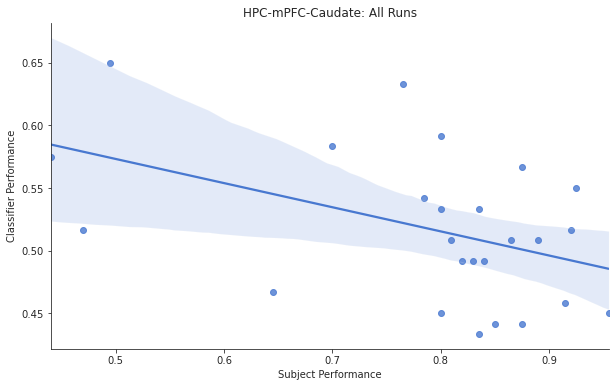

In [22]:
print(stats.spearmanr(all_data_df['svc_acc'], all_data_df['sub_acc']))
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.regplot(x = 'sub_acc', y = 'svc_acc', data = all_data_df)
sns.despine(top=True)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_ylabel('Classifier Performance')
ax.set_xlabel('Subject Performance')
ax.set_title('HPC-mPFC-Caudate: All Runs')
plt.show()